
# **<center><font style="color:rgb(100,109,254)">Human Action Recognition in Videos using Keras (CNN + LSTM)</font> </center>**


### **<font style="color:rgb(134,19,348)"> Import the Libraries</font>**



In [ ]:
# Discard the output of this cell.
%%capture

# Install the required libraries.
!pip install youtube-dl moviepy
!pip install git+https://github.com/pafy.git#egg=pafy

In [ ]:
# Import the required libraries.
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [ ]:
## Done to reduce the degree of randomness in the data and to make the data more less constant in all the runs that we will be doing

seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

## **<font style="color:rgb(134,19,348)">Step 1: Download and Visualize the Data with its Labels</font>**

In the first step, we will download and visualize the data along with labels to get an idea about what we will be dealing with. We will be using the [UCF50 - Action Recognition Dataset](https://www.crcv.ucf.edu/data/UCF50.php), consisting of realistic videos taken from youtube which differentiates this data set from most of the other available action recognition data sets as they are not realistic and are staged by actors. The Dataset contains:

*   **`50`** Action Categories

*   **`25`** Groups of Videos per Action Category

*   **`133`** Average Videos per Action Category

*   **`199`** Average Number of Frames per Video

*   **`320`** Average Frames Width per Video

*   **`240`** Average Frames Height per Video

*   **`26`** Average Frames Per Seconds per Video



In [ ]:
# Discard the output of this cell.
%%capture

# Downlaod the UCF50 Dataset
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar

#Extract the Dataset
!unrar x UCF50.rar

**For visualization, we will pick `20` random categories from the dataset and a random video from each selected category and will visualize the first frame of the selected videos with their associated labels written. This way we’ll be able to visualize a subset ( `20` random videos ) of the dataset.**

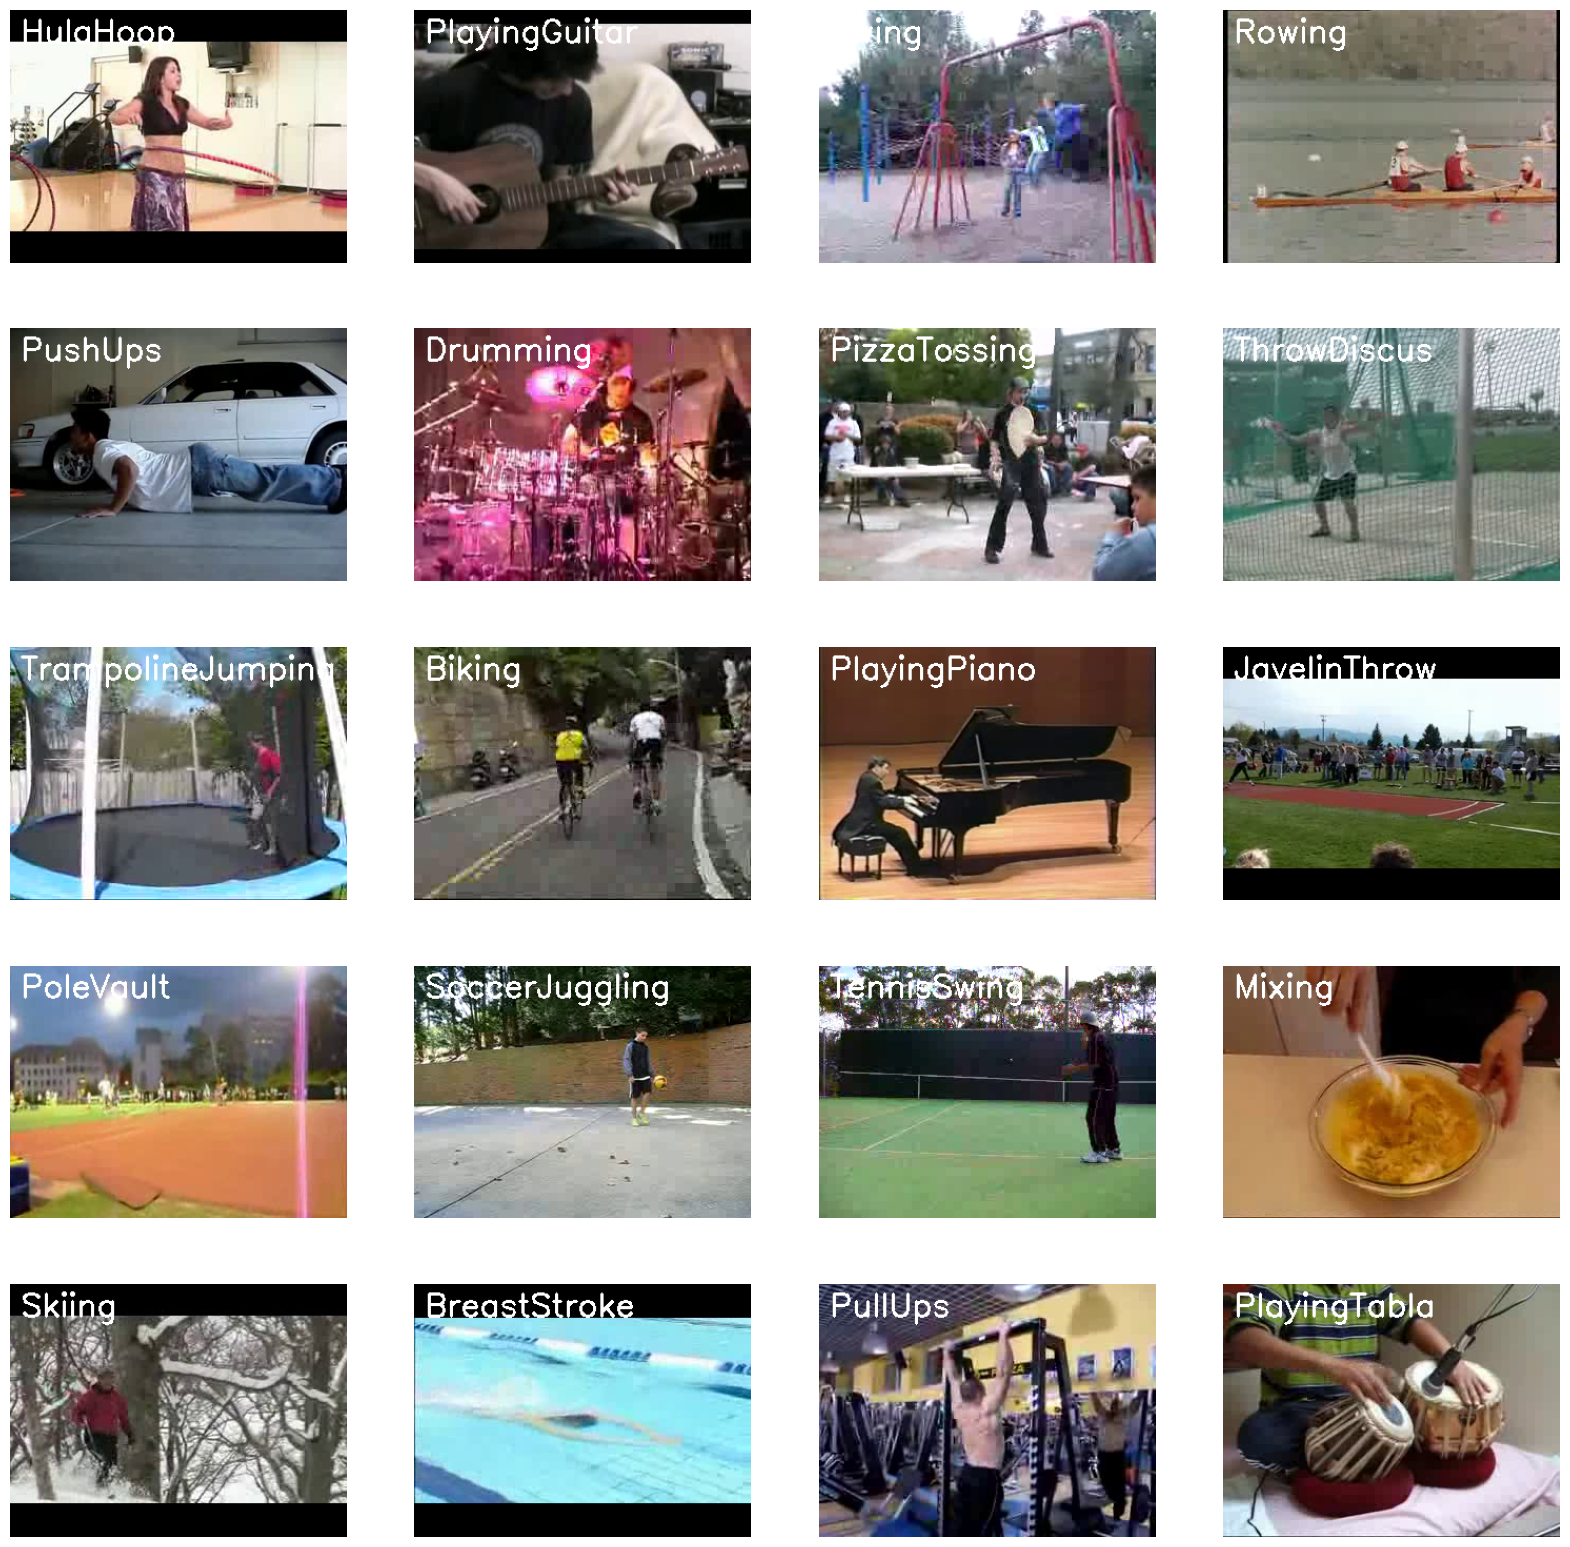

In [ ]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))

# Get the names of all classes/categories in UCF50.
all_classes_names = os.listdir('UCF50')

# Generate a list of 20 random values. The values will be between 0-50,
# where 50 is the total number of class in the dataset.
random_range = random.sample(range(len(all_classes_names)), 20)

# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):

    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]

    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'UCF50/{selected_class_Name}')

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'UCF50/{selected_class_Name}/{selected_video_file_name}')

    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object.
    video_reader.release()

    # Convert the frame from BGR into RGB format. Open CV default color scheme: BGR
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Display the frame.
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

## **<font style="color:rgb(134,19,348)">Step 2: Preprocess the Dataset</font>**

Next, we will perform some preprocessing on the dataset. First, we will read the video files from the dataset and resize the frames of the videos to a fixed width and height, to reduce the computations and normalized the data to range `[0-1]` by dividing the pixel values with `255`, which makes convergence faster while training the network.Initialize some constants

In [ ]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
# Since the LSTM works upon the sequential dataset
SEQUENCE_LENGTH = 20

# Specify the directory containing the UCF50 dataset.
DATASET_DIR = "UCF50"

# Specify the list containing the names of the classes used for training.
CLASSES_LIST = ["WalkingWithDog", "TaiChi", "Swing", "HorseRace"]



### **<font style="color:rgb(134,19,348)">Create a Function to Extract, Resize & Normalize Frames</font>**

A function **`frames_extraction()`** that will create a list containing the resized and normalized frames of a video whose path is passed to it as an argument. The function will read the video file frame by frame, although not all frames are added to the list as we will only need an evenly distributed sequence length of frames.

In [ ]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []

    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video.
        success, frame = video_reader.read()

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)

    # Release the VideoCapture object.
    video_reader.release()

    # Return the frames list.
    return frames_list

### **<font style="color:rgb(134,19,348)">Create a Function for Dataset Creation</font>**

 Create a function **`create_dataset()`** that will iterate through all the classes specified in the **`CLASSES_LIST`** constant and will call the function  **`frame_extraction()`** on every video file of the selected classes and return the frames (**`features`**), class index ( **`labels`**), and video file path (**`video_files_paths`**).

In [ ]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []

    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):

        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        # Iterate through all the files present in the files list.
        for file_name in files_list:

            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)

    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

**Now we will utilize the function `create_dataset()` created above to extract the data of the selected classes and create the required dataset.**

In [ ]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: WalkingWithDog
Extracting Data of Class: TaiChi
Extracting Data of Class: Swing
Extracting Data of Class: HorseRace


**Now we will convert `labels` (class indexes) into one-hot encoded vectors.**

In [ ]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

## **<font style="color:rgb(134,19,348)">Step 3: Split the Data into Train and Test Set</font>**

As of now, we have the required **`features`** (a NumPy array containing all the extracted frames of the videos) and **`one_hot_encoded_labels`** (also a Numpy array containing all class labels in one hot encoded format). So now, we will split our data to create training and testing sets. We will also shuffle the dataset before the split to avoid any bias and get splits representing the overall distribution of the data.

In [ ]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant)

## **<font style="color:rgb(134,19,348)">Implementing the LRCN Approach</font>**

In this step, we will implement another approach known as the Long-term Recurrent Convolutional Network (LRCN), which combines CNN and LSTM layers in a single model. The Convolutional layers are used for spatial feature extraction from the frames, and the extracted spatial features are fed to LSTM layer(s) at each time-steps for temporal sequence modeling. This way the network learns spatiotemporal features directly in an end-to-end training, resulting in a robust model.

<center>
<img src='https://drive.google.com/uc?export=download&id=1I-q5yLsIoNh2chfzT7JYvra17FsXvdme'>
</center>

We will also use [**`TimeDistributed`**](https://keras.io/api/layers/recurrent_layers/time_distributed/) wrapper layer, which allows applying the same layer to every frame of the video independently. So it makes a layer (around which it is wrapped) capable of taking input of shape `(no_of_frames, width, height, num_of_channels)` if originally the layer's input shape was `(width, height, num_of_channels)` which is very beneficial as it allows to input the whole video into the model in a single shot.

<center>
<img src='https://drive.google.com/uc?export=download&id=1CbauSm5XTY7ypHYBHH7rDSnJ5LO9CUWX' width=400>
</center>

### **<font style="color:rgb(134,19,348)">Construct the Model</font>**

To implement our LRCN architecture, we will use time-distributed **`Conv2D`** layers which will be followed by **`MaxPooling2D`** and **`Dropout`** layers. The feature extracted from the **`Conv2D`** layers will be then flattened using the  **`Flatten`** layer and will be fed to a **`LSTM`** layer. The **`Dense`** layer with softmax activation will then use the output from the **`LSTM`** layer to predict the action being performed.

In [ ]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(32))

    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed LRCN model.
    return model

**Now we will utilize the function `create_LRCN_model()` created above to construct the required `LRCN` model.**

In [ ]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()

# Display the success message.
print("Model Created Successfully!")

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 20, 64, 64, 16)      │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 20, 16, 16, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 20, 16, 16, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 20, 16, 16, 32)      │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 20, 4, 4, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 20, 4, 4, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, 20, 4, 4, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_7 (TimeDistributed) │ (None, 20, 2, 2, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_8 (TimeDistributed) │ (None, 20, 2, 2, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_9 (TimeDistributed) │ (None, 20, 2, 2, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_10                  │ (None, 20, 1, 1, 64)        │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_11                  │ (None, 20, 64)              │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 73,060 (285.39 KB)

 Trainable params: 73,060 (285.39 KB)

 Non-trainable params: 0 (0.00 B)

Model Created Successfully!


#### **<font style="color:rgb(134,19,348)">Check Model’s Structure:</font>**

**Now we will use the `plot_model()` function to check the structure of the constructed `LRCN` model. As we had checked for the previous model.**

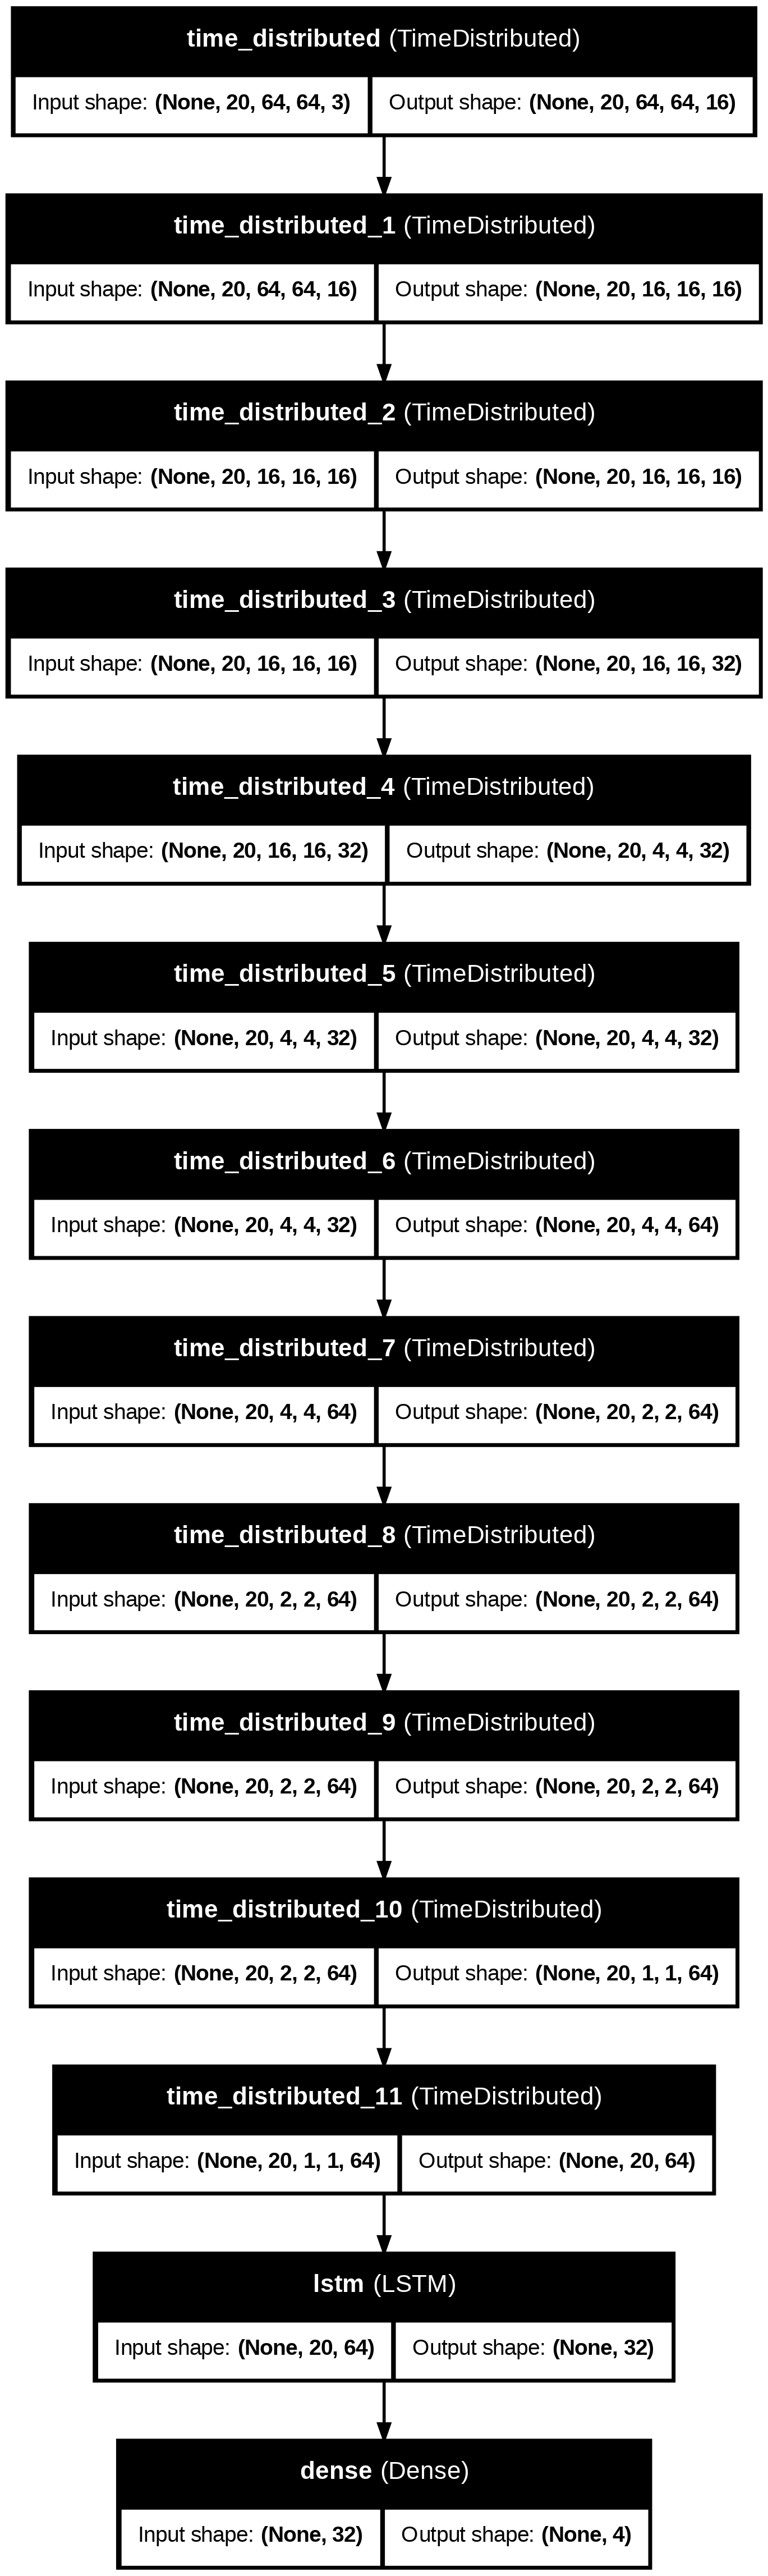

In [ ]:
# Plot the structure of the contructed LRCN model.
plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

### **<font style="color:rgb(134,19,348)">Step 5.2: Compile & Train the Model</font>**


**Compile and start training the model.**

In [ ]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 4 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 21s 81ms/step - accuracy: 0.2136 - loss: 1.4091 - val_accuracy: 0.3562 - val_loss: 1.3555
Epoch 2/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.2815 - loss: 1.3632 - val_accuracy: 0.2877 - val_loss: 1.2959
Epoch 3/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.4090 - loss: 1.3245 - val_accuracy: 0.5342 - val_loss: 1.1505
Epoch 4/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.5047 - loss: 1.1647 - val_accuracy: 0.5342 - val_loss: 1.1277
Epoch 5/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.5817 - loss: 0.9891 - val_accuracy: 0.6575 - val_loss: 0.8635
Epoch 6/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.6103 - loss: 0.8709 - val_accuracy: 0.6438 - val_loss: 0.9188
Epoch 7/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.6419 - loss: 0.8775 - val_accuracy: 0.7397 - val_loss: 0.6732
Epoch 8/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.7359 - loss: 0.6538 - val_accuracy: 0.7534 - 

#### **<font style="color:rgb(134,19,348)">Evaluating the trained Model</font>**

 **Evaluate the `LRCN` model on the test set.**

In [ ]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9232 - loss: 0.3936


#### **<font style="color:rgb(134,19,348)">Save the Model</font>**



In [ ]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save the Model.
LRCN_model.save(model_file_name)

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

### **<font style="color:rgb(134,19,348)">Plot Model’s Loss & Accuracy Curves</font>**


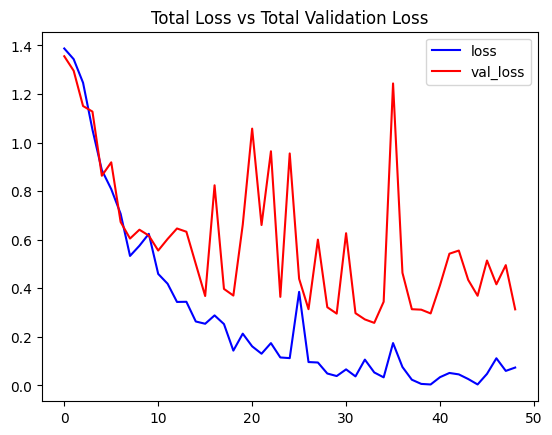

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

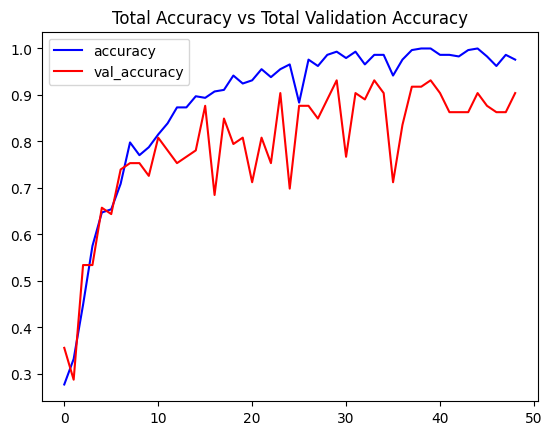

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

### **<font style="color:rgb(134,19,348)">Create a Function to Download YouTube Videos:</font>**

Create a function `download_youtube_videos()` to download the YouTube videos first using `pafy` library. The library only requires a URL to a video to download it along with its associated metadata like the title of the video.

In [ ]:
def download_youtube_videos(youtube_video_url, output_directory):
     '''
    This function downloads the youtube video whose URL is passed to it as an argument.
    Args:
        youtube_video_url: URL of the video that is required to be downloaded.
        output_directory:  The directory path to which the video needs to be stored after downloading.
    Returns:
        title: The title of the downloaded youtube video.
    '''

     # Create a video object which contains useful information about the video.
     video = pafy.new(youtube_video_url)

     # Retrieve the title of the video.
     title = video.title

     # Get the best available quality object for the video.
     video_best = video.getbest()

     # Construct the output file path.
     output_file_path = f'{output_directory}/{title}.mp4'

     # Download the youtube video at the best available quality and store it to the contructed path.
     video_best.download(filepath = output_file_path, quiet = True)

     # Return the video title.
     return title

### **<font style="color:rgb(134,19,348)">Download a Test Video:</font>**

The function `download_youtube_videos()` created above to download a youtube video on which the `LRCN` model will be tested.

In [ ]:
!pip install -U yt-dlp


In [ ]:
!pip install yt-dlp


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.1/172.1 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 64.5 MB/s eta 0:00:00


In [ ]:
import yt_dlp

def download_youtube_video(url, output_dir):
    ydl_opts = {
        'format': 'best[ext=mp4]',
        'outtmpl': f'{output_dir}/%(title)s.%(ext)s',
    }
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        info_dict = ydl.extract_info(url, download=True)
        video_title = info_dict.get('title', None)
    return video_title


### **<font style="color:rgb(134,19,348)">Create a Function To Perform Action Recognition on Videos</font>**

A function `predict_on_video()` that will simply read a video frame by frame from the path passed in as an argument and will perform action recognition on video and save the results.

In [ ]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform action recognition on a video using the LRCN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    output_file_path: The path where the ouput video with the predicted action being performed overlayed will be stored.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Initialize the VideoWriter Object to store the output video in the disk.
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'),
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

    # Declare a queue to store video frames.
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)

    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''

    # Iterate until the video is accessed successfully.
    while video_reader.isOpened():

        # Read the frame.
        ok, frame = video_reader.read()

        # Check if frame is not read properly then break the loop.
        if not ok:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list.
        frames_queue.append(normalized_frame)

        # Check if the number of frames in the queue are equal to the fixed sequence length.
        if len(frames_queue) == SEQUENCE_LENGTH:

            # Pass the normalized frames to the model and get the predicted probabilities.
            predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_queue, axis = 0))[0]

            # Get the index of class with highest probability.
            predicted_label = np.argmax(predicted_labels_probabilities)

            # Get the class name using the retrieved index.
            predicted_class_name = CLASSES_LIST[predicted_label]

        # Write predicted class name on top of the frame.
        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Write The frame into the disk using the VideoWriter Object.
        video_writer.write(frame)

    # Release the VideoCapture and VideoWriter objects.
    video_reader.release()
    video_writer.release()

### **<font style="color:rgb(134,19,348)">Perform Action Recognition on the Test Video</font>**
The function `predict_on_video()` created above to perform action recognition on the test video we had downloaded using the function `download_youtube_videos()` and display the output video with the predicted action overlayed on it.

In [ ]:
import os
import yt_dlp as youtube_dl
from IPython.display import Video, display

# Create a directory to save the videos if it doesn't exist
test_videos_directory = '/mnt/data/test_videos'
os.makedirs(test_videos_directory, exist_ok=True)

# Function to download a YouTube video
def download_youtube_video(url, output_dir):
    ydl_opts = {
        'format': 'best[ext=mp4]',  # Download the best mp4 format
        'outtmpl': f'{output_dir}/%(title)s.%(ext)s',  # Save the video with its title
    }

    with youtube_dl.YoutubeDL(ydl_opts) as ydl:
        info_dict = ydl.extract_info(url, download=True)
        video_title = info_dict.get('title', None)
        video_path = f"{output_dir}/{video_title}.mp4"

    return video_title, video_path

# Download the video from the provided URL
video_url = "https://www.youtube.com/watch?v=8u0qjmHIOcE"
video_title, video_path = download_youtube_video(video_url, test_videos_directory)

# Display the downloaded video using IPython's Video function (Colab compatible)
display(Video(video_path, embed=True))

# Confirm the video download
print(f"Downloaded video: {video_title}")


[youtube] Extracting URL: https://www.youtube.com/watch?v=8u0qjmHIOcE
[youtube] 8u0qjmHIOcE: Downloading webpage
[youtube] 8u0qjmHIOcE: Downloading ios player API JSON
[youtube] 8u0qjmHIOcE: Downloading mweb player API JSON
[youtube] 8u0qjmHIOcE: Downloading m3u8 information
[info] 8u0qjmHIOcE: Downloading 1 format(s): 18
[download] /mnt/data/test_videos/Test Video.mp4 has already been downloaded
[download] 100% of    1.25MiB


Downloaded video: Test Video


### **<font style="color:rgb(134,19,348)">Create a Function To Perform a Single Prediction on Videos</font>**

Create a function that will perform a single prediction for the complete videos. We will extract evenly distributed **N** **`(SEQUENCE_LENGTH)`** frames from the entire video and pass them to the `LRCN` model.

In [ ]:
def predict_single_action(video_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform single action recognition prediction on a video using the LRCN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Declare a list to store video frames we will extract.
    frames_list = []

    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''

    # Get the number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)

    # Iterating the number of times equal to the fixed length of sequence.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Read a frame.
        success, frame = video_reader.read()

        # Check if frame is not read properly then break the loop.
        if not success:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list
        frames_list.append(normalized_frame)

    # Passing the  pre-processed frames to the model and get the predicted probabilities.
    predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_list, axis = 0))[0]

    # Get the index of class with highest probability.
    predicted_label = np.argmax(predicted_labels_probabilities)

    # Get the class name using the retrieved index.
    predicted_class_name = CLASSES_LIST[predicted_label]

    # Display the predicted action along with the prediction confidence.
    print(f'Action Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')

    # Release the VideoCapture object.
    video_reader.release()

### **<font style="color:rgb(134,19,348)">Perform Single Prediction on a Test Video</font>**

Now we will utilize the function **`predict_single_action()`** created above to perform a single prediction on a complete youtube test video that we will download using the function **`download_youtube_videos()`**, we had created above.

In [ ]:
!pip install pytube


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 3.7 MB/s eta 0:00:00


In [ ]:
from IPython.display import display, HTML

# Display an enhanced, good-looking title with custom styling
display(HTML("""
    <h1 style="text-align:center; font-family: Arial, sans-serif;
               color: #6c7bfe;
               font-weight: bold;
               text-shadow: 2px 2px 8px rgba(0,0,0,0.3);
               background-color: #f0f4ff;
               padding: 20px;
               border-radius: 10px;
               box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.2);">
        Dashboard for Human Action Recognition in Videos using Keras (CNN + LSTM)
    </h1>
"""))


In [ ]:
import os
import time
import yt_dlp as youtube_dl
import ipywidgets as widgets
from IPython.display import display, Video
from datetime import datetime

# Create a directory to save the videos if it doesn't exist
test_videos_directory = '/mnt/data/test_videos'
os.makedirs(test_videos_directory, exist_ok=True)

# Function to download a YouTube video
def download_youtube_video(url, output_dir):
    ydl_opts = {
        'format': 'best[ext=mp4]',  # Download the best mp4 format
        'outtmpl': f'{output_dir}/%(title)s.%(ext)s',  # Save the video with its title
    }

    with youtube_dl.YoutubeDL(ydl_opts) as ydl:
        try:
            info_dict = ydl.extract_info(url, download=True)
            video_title = info_dict.get('title', None)
            video_path = f"{output_dir}/{video_title}.mp4"
        except Exception as e:
            return None, str(e)  # Return error message if download fails

    return video_title, video_path

# Function to simulate prediction (replace with your actual prediction logic)
def predict_single_action(video_file_path, sequence_length):
    # Placeholder for actual prediction logic
    time.sleep(2)  # Simulate prediction time
    return "Prediction: Walking"  # Sample prediction result

# Function to get current date and time
def get_current_datetime():
    return datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# Function to create and display the dashboard
def create_dashboard(video_url, sequence_length):
    # Step 1: Download the YouTube video
    video_title, video_path = download_youtube_video(video_url, test_videos_directory)

    if not video_path:
        result_text.value = f"Error: {video_title}"  # Show error message if download fails
        return

    # Step 2: Create progress bar for video download
    progress_bar.value = 0
    progress_bar.max = 100
    progress_bar.description = "Downloading Video..."

    # Simulate progress during download
    for i in range(1, 101):
        time.sleep(0.02)  # Simulate download progress
        progress_bar.value = i

    # Step 3: Simulate prediction
    prediction_result = predict_single_action(video_path, sequence_length)

    # Step 4: Create progress bar for prediction
    progress_bar.value = 0
    progress_bar.max = 100
    progress_bar.description = "Predicting..."

    # Simulate prediction processing time
    for i in range(1, 101):
        time.sleep(0.05)  # Simulating prediction processing time
        progress_bar.value = i

    # Step 5: Display the video and prediction result (ONLY ONCE)
    video_widget = Video(video_path, embed=True, width=640, height=480)

    # Update the result text with the prediction
    result_text.value = f"Prediction Result: {prediction_result}"

    # Display the video and prediction result (ensure it's shown only once)
    display(video_widget)

# Create widgets for the dashboard
title = widgets.HTML(value="<h1 style='text-align:center; font-family: Arial, sans-serif; color: #6c7bfe; font-weight: bold; text-shadow: 2px 2px 8px rgba(0,0,0,0.3); background-color: #f0f4ff; padding: 20px; border-radius: 10px; box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.2);'>Human Action Recognition in Videos using Keras (CNN + LSTM)</h1>")

video_url_input = widgets.Text(
    value="https://www.youtube.com/watch?v=8u0qjmHIOcE",
    description="Video URL:",
    width=500,
    style={'description_width': 'initial'}
)

sequence_length_input = widgets.IntSlider(
    value=30,
    min=1,
    max=100,
    step=1,
    description="Sequence Length:",
    continuous_update=False,
    style={'description_width': 'initial'}
)

run_button = widgets.Button(description="Run Prediction", button_style='success', style={'font_weight': 'bold'})

progress_bar = widgets.FloatProgress(value=0.0, min=0.0, max=100.0, description="Progress:", style={'description_width': 'initial'})

result_text = widgets.Label(value="", layout=widgets.Layout(margin='20px'))

# Date and Time widget
datetime_widget = widgets.HTML(value=f"<h3 style='text-align:center; color: #555;'>Current Date and Time: {get_current_datetime()}</h3>")

# Add background color to the dashboard container
ui = widgets.VBox([
    title,
    datetime_widget,  # Add current date and time to the UI
    video_url_input,
    sequence_length_input,
    run_button,
    progress_bar,
    result_text
], layout=widgets.Layout(
    background_color='#e7f4ff',  # Light blue background for the entire container
    padding='20px',  # Space around the widgets
    border_radius='10px',
    box_shadow='0px 4px 10px rgba(0,0,0,0.1)'  # Subtle shadow effect for the container
))

# Function to handle button click
def on_run_button_click(b):
    video_url = video_url_input.value
    sequence_length = sequence_length_input.value
    create_dashboard(video_url, sequence_length)

run_button.on_click(on_run_button_click)

# Display the UI (without duplicating the content display)
display(ui)


[youtube] Extracting URL: https://www.youtube.com/watch?v=8u0qjmHIOcE
[youtube] 8u0qjmHIOcE: Downloading webpage
[youtube] 8u0qjmHIOcE: Downloading ios player API JSON
[youtube] 8u0qjmHIOcE: Downloading mweb player API JSON
[youtube] 8u0qjmHIOcE: Downloading m3u8 information
[info] 8u0qjmHIOcE: Downloading 1 format(s): 18
[download] /mnt/data/test_videos/Test Video.mp4 has already been downloaded
[download] 100% of    1.25MiB
